## Definitions

In [227]:
FREQ_DIST_FILE = '../df-no-comas-service-linear-freqdist.pkl'
BI_FREQ_DIST_FILE = '../df-no-comas-service-linear-freqdist-bi.pkl'
FREQ_DIST_FILE_GLOVE = '../df-no-comas-original-linear-freqdist.pkl'
BI_FREQ_DIST_FILE_GLOVE = '../df-no-comas-original-linear-freqdist-bi.pkl'
DOC_FREQ_DIST_FILE = '../df-no-comas-service-linear-freqdist-doc.pkl'
DOC_BI_FREQ_DIST_FILE = '../df-no-comas-service-linear-freqdist-doc-bi.pkl'
TRAIN_PROCESSED_FILE = '../data_df_prod_has_likes-service-linear.csv'
TRAIN_PROCESSED_FILE = '../data_df_prod_has_likes-3-linear.csv'
#TRAIN_PROCESSED_FILE_GLOVE = '../data_df_prod_has_likes-original-linear.csv'

EXTERNAL_VAL_FILE = '../data_df_prod_no_likes-service-linear.csv'
#TEST_PROCESSED_FILE = 'test-2-processed.csv'

GLOVE_FILE = '../glove.6B.50d.txt'
DIM=50

TRAIN = True
UNIGRAM_SIZE = 10000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 5000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'naive_count'#'tfidf'

In [88]:
from keras.models import Sequential, load_model
from keras.layers import Dense,Dropout, Activation, TimeDistributed, LSTM, Embedding, Flatten, Masking
from keras.regularizers import l1,l2
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
import sys
import utils
import random
import numpy as np
import pandas as pd
import re
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

from sklearn.metrics import average_precision_score

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Performs classification using Logistic Regression.


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector


def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in range(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = np.zeros((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            #if feat_type == 'presence':
            #    tweet_words = set(tweet_words)
            #    tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels
        
def extract_X_y(tweets,feat_type=FEAT_TYPE):
    #Only one iteration
    if(FEAT_TYPE == 'naive_count'):
        for X, y in extract_features(tweets,feat_type=feat_type, batch_size=len(tweets), test_file=False):
            return X, y
    elif(FEAT_TYPE == 'tfidf'):
        features = np.zeros((len(tweets), VOCAB_SIZE))
        labels = np.zeros(len(tweets))
        for j, tweet in enumerate(tweets):
            tweet_words = tweet[2][0]
            tweet_bigrams = tweet[2][1]
            labels[j] = tweet[1]
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += inverse_doc_freq(doc_freq.get(word))/np.log(1+len(tweet_words))
                
            for bigram in tweet_bigrams:
                idx = bigrams.get(bigram)
                if idx:
                    features[j, UNIGRAM_SIZE + idx] += inverse_doc_freq(doc_freq.get(bigram))/np.log(1+len(tweet_bigrams))
        return features, labels
        
        
def inverse_doc_freq(querry_res):
    if querry_res == None: return np.log(1e5)
    else: return np.log(1e5/(1+querry_res))    

def sentence_to_vec(sentence):
    #unigrams and bigrams are externally defined dictionaries
    s_words,s_bigrams = get_feature_vector(sentence)
    features = np.zeros(VOCAB_SIZE)
    for word in s_words:
        idx = unigrams.get(word)
        if idx: features[idx] += 1
    for bigr in s_bigrams:
        idx = bigrams.get(word)
        if idx: features[UNIGRAM_SIZE + idx] += 1
    return features
        
        
def process_tweets(csv_file, test_file=True):
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, dummy, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            utils.write_status(i + 1, total)
    print ('\n')
    return tweets


def build_model(lr=0.001):
    model = Sequential()
    model.add(Dropout(0.4))
    model.add(Dense(1, #input_dim=VOCAB_SIZE,
                    activation='sigmoid',kernel_regularizer=l1(1e-4)))#consider l2 or mixed
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

def build_model_2(lr = 0.001, n1= 100):
    model = Sequential()
    model.add(Dropout(0.3))
    model.add(Dense(n1, #input_dim=VOCAB_SIZE, 
                    activation='relu',kernel_regularizer=l1(1e-4)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1(5e-5)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

def build_model_3(lr = 0.001, n1= 100, n2 = 30):
    model = Sequential()
    model.add(Dropout(0.3))
    model.add(Dense(n1, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-5)))
    model.add(Dropout(0.4))
    model.add(Dense(n2, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-4)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1(1e-5)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

def build_model_4(lr = 0.001, n1 = 50, n2= 100, n3 = 30):
    model = Sequential()
    model.add(Dropout(0.5))
    model.add(Dense(n1, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-4)))
    model.add(Dropout(0.2))
    model.add(Dense(n2, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-6)))
    model.add(Dropout(0.2))
    model.add(Dense(n3, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-6)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1(1e-5)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model


#def evaluate_model(model, val_tweets):
#    correct, total = 0, len(val_tweets)
#    for val_set_X, val_set_y in extract_features(val_tweets, feat_type=FEAT_TYPE, test_file=False):
#        prediction = model.predict_on_batch(val_set_X)
#        prediction = np.round(prediction)
#        correct += np.sum(prediction == val_set_y[:, None])
#    return float(correct) / total

def evaluate_model(model, val_tweets):
    correct, total = 0, len(val_tweets)
    for val_set_X, val_set_y in extract_features(val_tweets,batch_size=total, feat_type=FEAT_TYPE, test_file=False):
        prediction = model.predict_on_batch(val_set_X)
        prediction = np.round(prediction)
        correct += np.sum(prediction == val_set_y[:, None])

        pred = prediction
        truth = val_set_y

    save_to_file = open('compare-bi.csv', 'a')
    save_to_file.write('pred,truth\n')
    for i in range(len(pred)):
        save_to_file.write('%d,%d\n' % (pred[i],truth[i]))
        
    return float(correct) / total


def mean_pred(y_true, y_pred):
    return K.mean(y_pred)



def shuffle_split_data(tweets, validation_split=0.1,random_seed = 42):
    """Split the data into training and validation sets

    Args:
        tweets (list): list of tuples
        validation_split (float, optional): validation split %

    Returns:
        (list, list): training-set, validation-set
    """
    index = int((1 - validation_split) * len(tweets))
    random.Random(random_seed).shuffle(tweets)
    return tweets[:index], tweets[index:]
        
    
def stratifiedSplit(X,y,test_size=0.1,random_state=42):
    sss = StratifiedShuffleSplit(test_size=test_size,random_state=random_state,n_splits = 1)
    sss.get_n_splits(X,y)
    
    for train_id, test_id in sss.split(X, y):
        X_train_val,y_train_val = X[train_id], y[train_id]
        X_test,y_test = X[test_id], y[test_id]
    
    return X_train_val, y_train_val, X_test, y_test

def precision_recall(y_test,y_score,color='b'):
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color=color, alpha=0.6,
         where='post')
    #plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
def accuracy(y_test,y_score): return np.mean(y_test == (y_score>0.5))

def evaluate_model_pred(y_test,y_score,model_name):
    print(model_name+" has AP:", average_precision_score(y_test, y_score), 
      "accuracy", accuracy(y_test,y_score))
    precision_recall(y_test,y_score)
    
def show_significant_words(coeff,method='naive', length = 100):
    df_uni = pd.DataFrame.from_dict(unigrams,orient='index')
    df_bi = pd.DataFrame.from_dict(bigrams,orient='index')
    df_dict = pd.concat([df_uni, df_bi])
    big_pos_coeff = coeff.argsort()[-length:][::-1]
    big_neg_coeff = coeff.argsort()[:length]
    pos_res = []
    print(coeff[big_pos_coeff][0],coeff[big_pos_coeff][-1])
    print(coeff[big_neg_coeff][0],coeff[big_neg_coeff][-1])
    print('positive words are:')
    print([df_dict.iloc[idx].name for idx in big_pos_coeff] )
    print('negative words are:')
    print([df_dict.iloc[idx].name for idx in big_neg_coeff])
    
def precision_at_k(y_test,y_pred):
    y_pred = y_pred.reshape(-1)
    y_test_sorted = y_test[np.argsort(y_pred)]
    return [np.mean(y_test_sorted[-k-1:]) for k in np.arange(len(y_test))]

## Random Seed

In [3]:
#np.random.seed(1337)
random_seed = 33
np.random.seed(random_seed)

## Glove embedding

In [5]:
def get_glove_vectors(vocab):
    print('Looking for GLOVE vectors')
    glove_vectors = {}
    found = 0
    with open(GLOVE_FILE, 'r') as glove_file:
        for i, line in enumerate(glove_file):
            #utils.write_status(i + 1, 0)
            tokens = line.split()
            word = tokens[0]
            if vocab.get(word):
                vector = [float(e) for e in tokens[1:]]
                glove_vectors[word] = np.array(vector)
                found += 1
    print('\n')
    print('Found %d words in GLOVE' % found)
    return glove_vectors


def get_feature_vector_w2i(tweet):
    words = tweet.split()
    feature_vector = []
    for i in range(len(words) - 1):
        word = words[i]
        if vocab.get(word) is not None:
            feature_vector.append(vocab.get(word))
        else: 
            feature_vector.append(vocab.get('404MISSINGWORD404')) 
    if len(words) >= 1:
        if vocab.get(words[-1]) is not None:
            feature_vector.append(vocab.get(words[-1]))
    return feature_vector

def get_feature_vector_w2v(tweet):
    words = tweet.split()
    feature_vector = []
    for i in range(len(words)):
        word = words[i]
        if type(glove_vectors.get(word))!=type(None):
            feature_vector.append(glove_vectors.get(word))
        else: 
            feature_vector.append(glove_vectors.get('404MISSINGWORD404')) 
    #if len(words) >= 1:
    #    if vocab.get(words[-1]) is not None:
    #        feature_vector.append(vocab.get(words[-1]))
    return feature_vector


def process_tweets_w2i(csv_file, test_file=True):
    tweets = []
    labels = []
    print('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, dummy, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector_w2v(tweet)
            if test_file:
                tweets.append(feature_vector)
            else:
                tweets.append(feature_vector)
                labels.append(int(sentiment))
            #utils.write_status(i + 1, total)
    print('\n')
    return tweets, np.array(labels)

def process_tweets_w2v(csv_file, test_file=True):
    tweets = []
    labels = []
    print('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, dummy, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector_w2v(tweet)
            if test_file:
                tweets.append(feature_vector)
            else:
                tweets.append(feature_vector)
                labels.append(int(sentiment))
            #utils.write_status(i + 1, total)
    print('\n')
    return tweets, np.array(labels) 

def pad_vec_tweets(tweets, max_length):
    result = []
    for tweet in tweets:
        tweet = np.array(tweet)
        #print(tweet.shape)
        if len(tweet) == 0:
            result.append(np.zeros((max_length,DIM)))
        elif len(tweet)<max_length:
            padding = np.zeros((max_length-len(tweet),DIM))
            padded_tweet = np.concatenate([tweet,padding])
            result.append(padded_tweet)
        else:
            result.append(tweet[:max_length])
    return np.array(result)

In [7]:
train = True
np.random.seed(1337)
#np.random.seed(42)
vocab_size = 54488 + 1
batch_size = 500
max_length = 100
filters = 600
kernel_size = 3

vocab = utils.top_n_words(FREQ_DIST_FILE_GLOVE, vocab_size-1, shift=1)
glove_vectors = get_glove_vectors(vocab)
#Handle unkown words

vocab['404MISSINGWORD404'] = vocab_size
glove_vectors['404MISSINGWORD404']=np.mean([v for _,v in glove_vectors.items()],axis = 0)

Looking for GLOVE vectors


Found 36502 words in GLOVE


In [99]:
def word2vec(word, glove_vectors=glove_vectors):
    if type(glove_vectors.get(word.lower()))!=type(None): 
        return glove_vectors[word.lower()]
    else: 
        return glove_vectors['404MISSINGWORD404']
    
def sentence2vec(sentence, glove_vectors=glove_vectors):
    return np.sum([word2vec(word,glove_vectors=glove_vectors) for word in sentence.split()],axis=0)

### Bag of words type embedding

In [11]:
#use bag of words together with embedding
unigrams_org = utils.top_n_words(FREQ_DIST_FILE_GLOVE, UNIGRAM_SIZE)
bigrams_org = utils.top_n_bigrams(BI_FREQ_DIST_FILE_GLOVE, BIGRAM_SIZE)

unigrams = unigrams_org
bigrams = bigrams_org

tweets = process_tweets(TRAIN_PROCESSED_FILE_GLOVE, test_file=False)
X,y = extract_X_y(tweets,feat_type=FEAT_TYPE)

del unigrams
del bigrams

Generating feature vectors
Processing 2726/32367

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 7270/32367

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 32367/32367



In [43]:
#glove_matrix_uni = []
#for key in unigrams_org:
#    if(unigrams_org[key]!=len(glove_matrix_uni)): 
#        print('error')
#        break
#    glove_matrix_uni.append(word2vec(key))
#glove_matrix_uni = np.array(glove_matrix_uni)
glove_matrix_uni = np.array([word2vec(key) for key in unigrams_org])
glove_matrix_uni.shape

glove_matrix_bi = np.array([np.concatenate([word2vec(key[0]),word2vec(key[1])]) for key in bigrams_org])
glove_matrix_bi.shape

(5000, 100)

In [50]:
#Embeded version of the bag of words
X_emb = np.concatenate([X[:,:UNIGRAM_SIZE]@glove_matrix_uni, X[:,UNIGRAM_SIZE:]@glove_matrix_bi],axis = 1)

X_emb.shape

(32367, 150)

In [51]:
X=X_emb

X_train_val,y_train_val,X_test, y_test = stratifiedSplit(X,y,test_size = 0.1, random_state = random_seed)
X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,test_size = 0.1, random_state = random_seed+1)

print(len(y_train),len(y_val),len(y_test))
print(np.mean(y_train == 1),np.mean(y_val == 1),np.mean(y_test == 1))

del X,X_emb,y

26217 2913 3237
0.34683602242819545 0.3467215928595949 0.34692616620327466


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


0.6738757294884998
logistic has AP: 0.47957045199038895 accuracy 0.6784059314179796


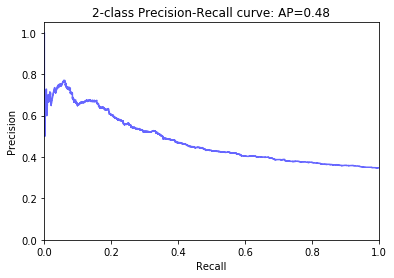

In [53]:
logistic = LogisticRegression(random_state=0,verbose=1,solver='lbfgs')
logistic.fit(X_train, y_train)

pred_val_logistic = logistic.predict_proba(X_val)[:,1]
print(np.mean((pred_val_logistic>0.5) == y_val))

y_score_logistic = logistic.predict_proba(X_test)[:,1]
evaluate_model_pred(y_test,y_score_logistic,model_name='logistic')

In [54]:
model = build_model(lr = 0.001)

W0929 22:28:11.550383 4559943104 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 22:28:11.744082 4559943104 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [55]:
model.fit(X_train, y_train, batch_size=100, epochs=10, validation_data = (X_val,y_val), shuffle=True)

W0929 22:28:16.795151 4559943104 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0929 22:28:16.803641 4559943104 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0929 22:28:16.813122 4559943104 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0929 22:28:16.836168 4559943104 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backen

Train on 26217 samples, validate on 2913 samples
Epoch 1/10
26217/26217 [==============================] - 2s 78us/step - loss: 2.2365 - acc: 0.5592 - mean_pred: 0.3703 - val_loss: 1.0045 - val_acc: 0.6069 - val_mean_pred: 0.3144
Epoch 2/10
26217/26217 [==============================] - 1s 42us/step - loss: 1.0418 - acc: 0.5836 - mean_pred: 0.4101 - val_loss: 0.7099 - val_acc: 0.6519 - val_mean_pred: 0.3494
Epoch 3/10
26217/26217 [==============================] - 1s 42us/step - loss: 0.7124 - acc: 0.6320 - mean_pred: 0.4040 - val_loss: 0.6645 - val_acc: 0.6560 - val_mean_pred: 0.3381
Epoch 4/10
26217/26217 [==============================] - 1s 41us/step - loss: 0.6593 - acc: 0.6534 - mean_pred: 0.3820 - val_loss: 0.6455 - val_acc: 0.6588 - val_mean_pred: 0.3378
Epoch 5/10
26217/26217 [==============================] - 1s 41us/step - loss: 0.6545 - acc: 0.6570 - mean_pred: 0.3727 - val_loss: 0.6402 - val_acc: 0.6660 - val_mean_pred: 0.3736
Epoch 6/10
26217/26217 [======================

1 layer has AP: 0.4459924904300185 accuracy 0.6445618504530706


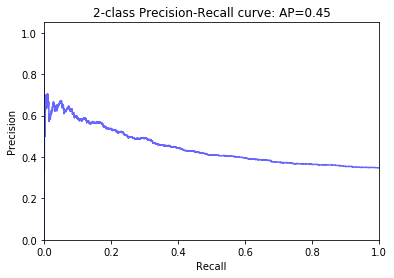

In [56]:
y_model = model.predict(X_test)
evaluate_model_pred(y_test,y_model,model_name='1 layer')

In [80]:
def build_model_2(lr = 0.001, n1= 100):
    model = Sequential()
    model.add(Dropout(0.1))
    model.add(Dense(n1, #input_dim=VOCAB_SIZE, 
                    activation='relu'))#,kernel_regularizer=l1(1e-4)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))#,kernel_regularizer=l1(5e-5)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

model_2 = build_model_2(lr = 5e-3, n1 = 100)

In [81]:
model_2.fit(X_train, y_train, batch_size=300, epochs=30, validation_data = (X_val,y_val), shuffle=True)

Train on 26217 samples, validate on 2913 samples
Epoch 1/30
26217/26217 [==============================] - 2s 80us/step - loss: 1.0701 - acc: 0.6013 - mean_pred: 0.3936 - val_loss: 0.6612 - val_acc: 0.6478 - val_mean_pred: 0.4063
Epoch 2/30
26217/26217 [==============================] - 1s 28us/step - loss: 0.6608 - acc: 0.6503 - mean_pred: 0.3844 - val_loss: 0.6402 - val_acc: 0.6636 - val_mean_pred: 0.3604
Epoch 3/30
26217/26217 [==============================] - 1s 28us/step - loss: 0.6308 - acc: 0.6667 - mean_pred: 0.3649 - val_loss: 0.6315 - val_acc: 0.6715 - val_mean_pred: 0.3860
Epoch 4/30
26217/26217 [==============================] - 1s 29us/step - loss: 0.6267 - acc: 0.6669 - mean_pred: 0.3606 - val_loss: 0.6279 - val_acc: 0.6619 - val_mean_pred: 0.3469
Epoch 5/30
26217/26217 [==============================] - 1s 28us/step - loss: 0.6195 - acc: 0.6710 - mean_pred: 0.3545 - val_loss: 0.6292 - val_acc: 0.6622 - val_mean_pred: 0.3330
Epoch 6/30
26217/26217 [======================

2-layer has AP: 0.47756367128470484 accuracy 0.6090952531878423


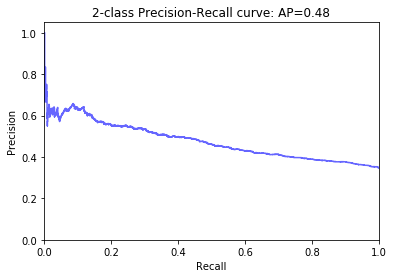

In [82]:
y_model_2 = model_2.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_2,model_name='2-layer')

In [85]:
def build_model_3(lr = 0.001, n1= 100, n2 = 30):
    model = Sequential()
    model.add(Dropout(0.1))
    model.add(Dense(n1, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(n2, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1(1e-5)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

model_3 = build_model_3(lr = 5e-3, n1 = 150, n2 = 100)

In [86]:
model_3.fit(X_train, y_train, batch_size=300, epochs=30, validation_data = (X_val,y_val), shuffle=True)

Train on 26217 samples, validate on 2913 samples
Epoch 1/30
26217/26217 [==============================] - 3s 118us/step - loss: 1.1193 - acc: 0.6176 - mean_pred: 0.4021 - val_loss: 0.6767 - val_acc: 0.6522 - val_mean_pred: 0.4215
Epoch 2/30
26217/26217 [==============================] - 1s 42us/step - loss: 0.6702 - acc: 0.6601 - mean_pred: 0.3903 - val_loss: 0.6601 - val_acc: 0.6656 - val_mean_pred: 0.3879
Epoch 3/30
26217/26217 [==============================] - 1s 42us/step - loss: 0.6548 - acc: 0.6638 - mean_pred: 0.3660 - val_loss: 0.6524 - val_acc: 0.6704 - val_mean_pred: 0.3696
Epoch 4/30
26217/26217 [==============================] - 1s 42us/step - loss: 0.6489 - acc: 0.6674 - mean_pred: 0.3594 - val_loss: 0.6477 - val_acc: 0.6711 - val_mean_pred: 0.3674
Epoch 5/30
26217/26217 [==============================] - 1s 42us/step - loss: 0.6455 - acc: 0.6696 - mean_pred: 0.3540 - val_loss: 0.6463 - val_acc: 0.6725 - val_mean_pred: 0.3479
Epoch 6/30
26217/26217 [=====================

2-layer has AP: 0.48094381819647036 accuracy 0.6209174522762517


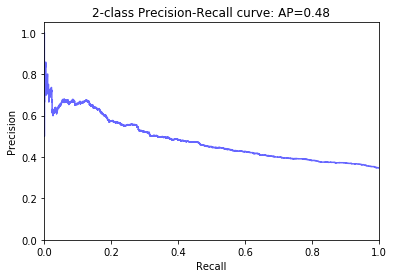

In [87]:
y_model_3 = model_3.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_3,model_name='2-layer')

### LSTM type embedding

In [249]:

tweets_vec, labels = process_tweets_w2v(TRAIN_PROCESSED_FILE, test_file=False)
tweets_vec_padded = pad_vec_tweets(tweets_vec, max_length=max_length)

tweets_vec_padded.shape

Generating feature vectors




(32367, 100, 50)

In [197]:
y=labels
#X=tweets_padded.reshape(-1,DIM*max_length)
X=tweets_vc_padded

X_train_val,y_train_val,X_test, y_test = stratifiedSplit(X,y,test_size = 0.1, random_state = random_seed)
X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,test_size = 0.1, random_state = random_seed+1)

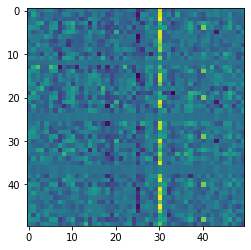

In [157]:
plt.imshow(tweets_padded[209][:50])

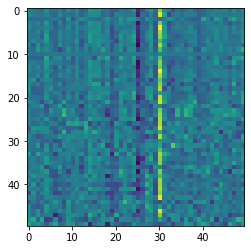

In [158]:
plt.imshow(tweets_padded[203][:50])

In [ ]:
tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)

In [226]:
lstm = Sequential()
#lstm.add(Embedding(vocab_size + 1, DIM, weights=[embedding_matrix],mask_zero=True,trainable=True,embeddings_regularizer=l1(1e-4)))#, input_length=max_length,trainable = False))
lstm.add(Masking(mask_value=0., input_shape=(max_length, DIM)))
lstm.add(LSTM(40,return_sequences=True))#input_shape=(max_length,DIM)
               #bias_regularizer=l1(5e-4),recurrent_regularizer=l1(5e-4),kernel_regularizer=l1(5e-4),dropout=0.2))
lstm.add(LSTM(10))#input_shape=(max_length,DIM)
#lstm.add(Flatten())
lstm.add(Dense(1,kernel_regularizer=l1(0.00001)))
lstm.add(Activation('sigmoid'))
adam_opt = Adam(lr=0.01)
lstm.compile(loss='binary_crossentropy', optimizer=adam_opt, metrics=['accuracy',mean_pred])
print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 100, 50)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 100, 40)           14560     
_________________________________________________________________
lstm_42 (LSTM)               (None, 10)                2040      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_18 (Activation)   (None, 1)                 0         
Total params: 16,611
Trainable params: 16,611
Non-trainable params: 0
_________________________________________________________________
None


In [240]:
lstm.fit(X_train, y_train, batch_size=500, epochs=5, validation_data = (X_val,y_val), shuffle=True)

Train on 26217 samples, validate on 2913 samples
Epoch 1/5
26217/26217 [==============================] - 56s 2ms/step - loss: 0.3391 - acc: 0.8499 - mean_pred: 0.3492 - val_loss: 0.9293 - val_acc: 0.6220 - val_mean_pred: 0.3704
Epoch 2/5
26217/26217 [==============================] - 57s 2ms/step - loss: 0.3268 - acc: 0.8570 - mean_pred: 0.3460 - val_loss: 0.9727 - val_acc: 0.5980 - val_mean_pred: 0.3893
Epoch 3/5
26217/26217 [==============================] - 57s 2ms/step - loss: 0.3209 - acc: 0.8590 - mean_pred: 0.3471 - val_loss: 1.0127 - val_acc: 0.6073 - val_mean_pred: 0.3804
Epoch 4/5
26217/26217 [==============================] - 66s 3ms/step - loss: 0.3003 - acc: 0.8717 - mean_pred: 0.3490 - val_loss: 0.9994 - val_acc: 0.6203 - val_mean_pred: 0.3548
Epoch 5/5
26217/26217 [==============================] - 64s 2ms/step - loss: 0.2923 - acc: 0.8727 - mean_pred: 0.3466 - val_loss: 1.0549 - val_acc: 0.6200 - val_mean_pred: 0.3520


lstm has AP: 0.4636436923859387 accuracy 0.5553751805301098


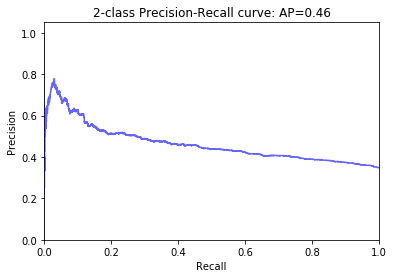

In [241]:
y_lstm = lstm.predict(X_test)
evaluate_model_pred(y_test,y_lstm,model_name='lstm')

## Trad embedding

In [228]:
unigrams = utils.top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
bigrams = utils.top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)

with open(DOC_FREQ_DIST_FILE, 'rb') as pkl_file:
        doc_freq = pickle.load(pkl_file)
with open(DOC_BI_FREQ_DIST_FILE, 'rb') as pkl_file:
        doc_freq_bi = pickle.load(pkl_file)
    
tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)

Generating feature vectors
Processing 32260/32367Processing 31780/32367



In [306]:
'''
#need full words instead of stemmer
tweets_mean_vec=[]
for a_t_vec in tweets_vec:
    if len(a_t_vec)==0: tweets_mean_vec.append(np.zeros(DIM))
    else: tweets_mean_vec.append(np.mean(a_t_vec,axis=0))
tweets_mean_vec = np.array(tweets_mean_vec)
tweets_mean_vec.shape
'''

(32367, 50)

In [229]:
X,y = extract_X_y(tweets,feat_type=FEAT_TYPE)
#X_r = np.concatenate([X,tweets_mean_vec],axis=1)

X_train_val,y_train_val,X_test, y_test = stratifiedSplit(X,y,test_size = 0.1, random_state = random_seed)
X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,test_size = 0.1, random_state = random_seed+1)

print(len(y_train),len(y_val),len(y_test))
print(np.mean(y_train == 1),np.mean(y_val == 1),np.mean(y_test == 1))

#del X,y

26217 2913 3237
0.08788190868520426 0.08788190868520426 0.08804448563484708


## Trad embedding with title glove embedded

In [100]:
df = pd.read_csv(TRAIN_PROCESSED_FILE,header=None)
df.columns=['id','n_likes','text']
df.set_index('id')

df_titles = pd.read_csv("../df-no-comas-title-linear.csv",header=None)
df_titles.columns=['id','n_likes','title']
df_titles.set_index('id')

title_dict = dict(np.array([df_titles.id.values,df_titles.title.values]).T)

titles = [title_dict[idd] for idd in df.id.values]

titles_vec = np.array([sentence2vec(title) for title in titles])

In [116]:
unigrams = utils.top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
if USE_BIGRAMS: bigrams = utils.top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    
tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)
X,y = extract_X_y(tweets,feat_type=FEAT_TYPE)

#Add the title vectors
#X = np.concatenate([X,titles_vec],axis=1)

X_train_val,y_train_val,X_test, y_test = stratifiedSplit(X,y,test_size = 0.1, random_state = random_seed)
X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,test_size = 0.1, random_state = random_seed+1)

print(len(y_train),len(y_val),len(y_test))
print(np.mean(y_train == 1),np.mean(y_val == 1),np.mean(y_test == 1))

Generating feature vectors
Processing 2938/32367

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Processing 32367/32367Processing 17647/32367

26217 2913 3237
0.34683602242819545 0.3467215928595949 0.34692616620327466


In [117]:
X.shape

(32367, 15000)

## Modeling

In [230]:
X_train.shape

(26217, 15000)

In [7]:
logistic = LogisticRegression(random_state=0,verbose=1,solver='lbfgs')
logistic.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

0.9073120494335737
logistic has AP: 0.2838100739565732 accuracy 0.9023787457522398


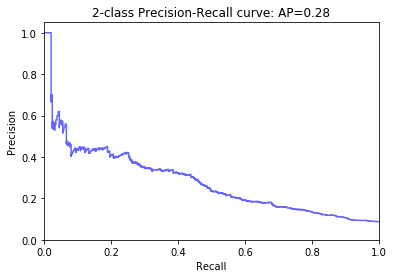

In [8]:
pred_val_logistic = logistic.predict_proba(X_val)[:,1]

print(np.mean((pred_val_logistic>0.5) == y_val))

y_score_logistic = logistic.predict_proba(X_test)[:,1]
evaluate_model_pred(y_test,y_score_logistic,model_name='logistic')

In [9]:
X_train_mean_excluding_0 = np.nan_to_num(np.nanmean(np.where(np.isclose(X_train,0), np.nan, X_train),axis=0))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [10]:
X_train_std = np.std(X_train,axis=0)

In [11]:
show_significant_words(logistic.coef_[0]*X_train_mean_excluding_0)
show_significant_words(logistic.coef_[0]*X_train_std)

4.151472190065908 1.1218492535925249
-6.535078638289743 -0.995647032903909
positive words are:
['col', 'img', ('num', 'ngc'), 'unbox', ('mark', 'num'), 'trailblaz', 'crater', 'bidder', 'bhz', 'perplex', 'slim', ('ngc', 'num'), 'thoma', 'rubi', 'aesthet', 'vote', ('best', 'planetari'), 'optec', 'omg', 'tast', 'warehous', 'airplan', 'trim', 'wx', 'lrgb', 'ipolar', ('num', 'owner'), 'facebook', 'platesolv', 'nz', ('see', 'c'), 'nerd', 'baggag', 'hotel', ('mm', 'version'), ('manag', 'get'), 'babi', 'dirti', ('tfov', 'num'), 'hdx', 'absurd', 'wavefront', 'planewav', ('night', 'use'), ('num', 'achromat'), 'fart', ('best', 'num'), 'covert', 'asiair', ('planetari', 'imag'), ('degre', 'tfov'), 'dent', 'tariff', 'jar', 'horsepow', 'fault', ('num', 'pro'), ('use', 'test'), ('mm', 'delo'), 'unitron', 'nah', ('make', 'one'), 'checkout', ('got', 'one'), 'edt', 'meter', 'diffract', 'rgb', 'covet', 'caldwel', 'emil', 'glp', 'pave', ('tri', 'look'), 'megrez', ('caus', 'problem'), ('differ', 'apertur'),

In [245]:
model = build_model(lr = 0.005)

In [246]:
class_weight = {0: 1.,1: 10.}

model.fit(X_train, y_train, batch_size=100, 
          epochs=10, validation_data = (X_val,y_val),class_weight=class_weight, shuffle=True)

Train on 26217 samples, validate on 2913 samples
Epoch 1/10
26217/26217 [==============================] - 21s 809us/step - loss: 1.2102 - acc: 0.6584 - mean_pred: 0.4652 - val_loss: 0.7152 - val_acc: 0.7192 - val_mean_pred: 0.4497
Epoch 2/10
26217/26217 [==============================] - 17s 665us/step - loss: 1.0555 - acc: 0.7851 - mean_pred: 0.3943 - val_loss: 0.6067 - val_acc: 0.8205 - val_mean_pred: 0.3644
Epoch 3/10
26217/26217 [==============================] - 18s 692us/step - loss: 1.0009 - acc: 0.8137 - mean_pred: 0.3671 - val_loss: 0.6315 - val_acc: 0.8136 - val_mean_pred: 0.3640
Epoch 4/10
26217/26217 [==============================] - 18s 676us/step - loss: 0.9662 - acc: 0.8304 - mean_pred: 0.3512 - val_loss: 0.6297 - val_acc: 0.8191 - val_mean_pred: 0.3530
Epoch 5/10
26217/26217 [==============================] - 17s 667us/step - loss: 0.9561 - acc: 0.8370 - mean_pred: 0.3410 - val_loss: 0.6464 - val_acc: 0.8181 - val_mean_pred: 0.3502
Epoch 6/10
26217/26217 [============

In [208]:
#model.save('model_rele_n_like_3.h5')

1 layer has AP: 0.2939569406824772 accuracy 0.7829092086604063


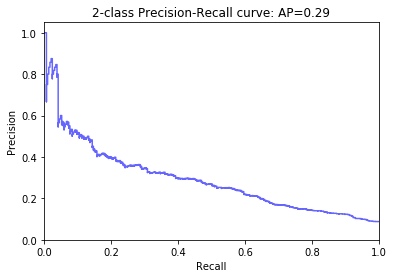

In [247]:
y_model = model.predict(X_test)
evaluate_model_pred(y_test,y_model,model_name='1 layer')

#show_significant_words(model.layers[1].get_weights()[0].reshape(-1)*X_train_mean_excluding_0)

#show_significant_words(model.layers[1].get_weights()[0].reshape(-1)*X_train_std)

In [248]:
np.mean(y_model<0.5)

0.8433734939759037

In [249]:
split = 10
unit_len = int(len(y_test)/split)
precision_at_k_all = []
for i in range(split):
    precision_at_k_all.append(precision_at_k(y_test[i*unit_len:(i+1)*unit_len],y_model[i*unit_len:(i+1)*unit_len]))
precision_at_k_all = np.array(precision_at_k_all)
precision_at_k_all.shape

pr_at_k = np.mean(precision_at_k_all,axis = 0)

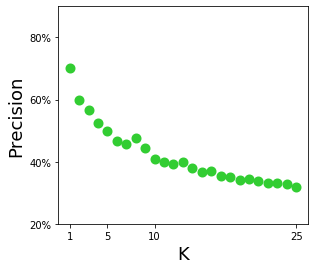

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.arange(plot_len)+1,pr_at_k[:plot_len],color='limegreen',lw=4)
ax.set_ylim([0.5, 0.9])
ax.set_xlabel('K',fontsize=18)
ax.set_ylabel('Precision',fontsize=18)
#ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax.yaxis.set_ticks([0.2,0.4,0.6,0.8])
ax.set_yticklabels(['20%','40%','60%','80%'])
ax.xaxis.set_ticks([1,5,10,25])
ax.set_aspect(aspect=32.9)
plt.show()

In [ ]:
ax.plot(fpr, tpr, color='limegreen',lw=lw*1.5, label='Logistic (area: %0.2f)' % roc_auc)
ax.plot(fprb, tprb, color='grey',lw=lw/1.5, label='Vader (area: %0.2f)' % roc_aucb)
ax.plot([0, 1], [0, 1], color='navy', lw=lw/2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.01])
ax.xaxis.set_ticks([0,1])
ax.yaxis.set_ticks([0,1])
ax.set_xlabel('False Positive Rate',fontsize=13)
ax.set_ylabel('True Positive Rate',fontsize=13)
ax.legend(loc="lower right")
ax.set_aspect(aspect=0.9)

In [404]:
model.save('model_pre_59.h5')

In [113]:
model_2 = build_model_2(lr = 1e-3, n1 = 50)

In [114]:
model_2.fit(X_train, y_train, batch_size=300, epochs=5, validation_data = (X_val,y_val), shuffle=True)

Train on 26217 samples, validate on 2913 samples
Epoch 1/5
26217/26217 [==============================] - 20s 762us/step - loss: 0.7835 - acc: 0.6728 - mean_pred: 0.3828 - val_loss: 0.6557 - val_acc: 0.7024 - val_mean_pred: 0.3475
Epoch 2/5
26217/26217 [==============================] - 19s 707us/step - loss: 0.6538 - acc: 0.7000 - mean_pred: 0.3626 - val_loss: 0.6397 - val_acc: 0.7113 - val_mean_pred: 0.3581
Epoch 3/5
26217/26217 [==============================] - 19s 739us/step - loss: 0.6450 - acc: 0.7109 - mean_pred: 0.3587 - val_loss: 0.6356 - val_acc: 0.7212 - val_mean_pred: 0.3597
Epoch 4/5
26217/26217 [==============================] - 18s 704us/step - loss: 0.6407 - acc: 0.7125 - mean_pred: 0.3546 - val_loss: 0.6305 - val_acc: 0.7230 - val_mean_pred: 0.3555
Epoch 5/5
26217/26217 [==============================] - 18s 693us/step - loss: 0.6362 - acc: 0.7146 - mean_pred: 0.3526 - val_loss: 0.6303 - val_acc: 0.7226 - val_mean_pred: 0.3498


2-layer has AP: 0.6493225774080131 accuracy 0.5987862955827492


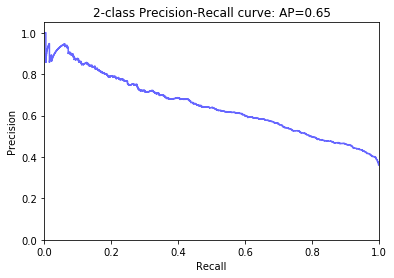

In [115]:
y_model_2 = model_2.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_2,model_name='2-layer')

In [415]:
model_2.save('model_2_pre.h5')

In [328]:
model_3 = build_model_3(lr = 0.001, n1 = 100, n2 = 30)

In [344]:
model_3.fit(X_train, y_train, batch_size=400, epochs=2, validation_data = (X_val,y_val), shuffle=True)

Train on 26217 samples, validate on 2913 samples
Epoch 1/2
26217/26217 [==============================] - 54s 2ms/step - loss: 0.5166 - acc: 0.9014 - mean_pred: 0.3448 - val_loss: 1.0103 - val_acc: 0.6728 - val_mean_pred: 0.3341
Epoch 2/2
26217/26217 [==============================] - 52s 2ms/step - loss: 0.5077 - acc: 0.9093 - mean_pred: 0.3455 - val_loss: 1.0100 - val_acc: 0.6804 - val_mean_pred: 0.3353


3-layer has AP: 0.5725629347421588 accuracy 0.5659678709133247


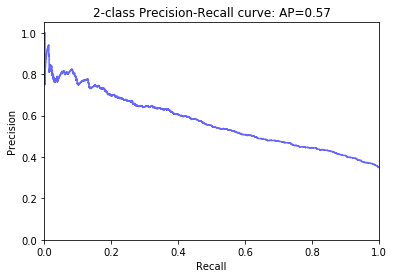

In [345]:
y_model_3 = model_3.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_3,model_name='3-layer')

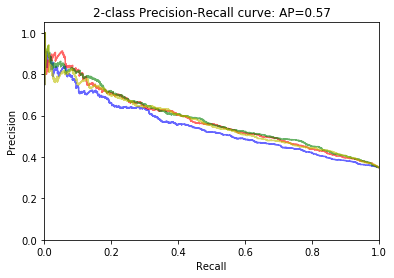

In [347]:
precision_recall(y_test,y_score_logistic)
precision_recall(y_test,y_model,color='r')
precision_recall(y_test,y_model_2,color='g')
precision_recall(y_test,y_model_3,color='y')
plt.show()

In [332]:
model_4 = build_model_4(lr = 0.001, n1 = 70, n2=100, n3 = 30)

In [358]:
model_4.fit(X_train, y_train, batch_size=400, epochs=5, validation_data = (X_val,y_val), shuffle=True)

Train on 26217 samples, validate on 2913 samples
Epoch 1/5
26217/26217 [==============================] - 54s 2ms/step - loss: 0.8216 - acc: 0.7224 - mean_pred: 0.3503 - val_loss: 0.8658 - val_acc: 0.6996 - val_mean_pred: 0.3499
Epoch 2/5
26217/26217 [==============================] - 51s 2ms/step - loss: 0.8318 - acc: 0.7290 - mean_pred: 0.3449 - val_loss: 0.8833 - val_acc: 0.6900 - val_mean_pred: 0.3854
Epoch 3/5
26217/26217 [==============================] - 51s 2ms/step - loss: 0.8306 - acc: 0.7333 - mean_pred: 0.3508 - val_loss: 0.8948 - val_acc: 0.6876 - val_mean_pred: 0.3556
Epoch 4/5
26217/26217 [==============================] - 62s 2ms/step - loss: 0.8235 - acc: 0.7454 - mean_pred: 0.3454 - val_loss: 0.8953 - val_acc: 0.6914 - val_mean_pred: 0.3694
Epoch 5/5
26217/26217 [==============================] - 64s 2ms/step - loss: 0.8259 - acc: 0.7462 - mean_pred: 0.3505 - val_loss: 0.8952 - val_acc: 0.6955 - val_mean_pred: 0.3335


3-layer has AP: 0.5725629347421588 accuracy 0.5659678709133247


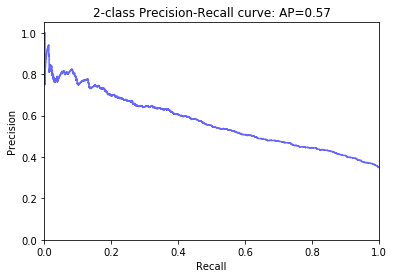

In [359]:
y_model_4 = model_3.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_4,model_name='4-layer')

In [360]:
model.save('model_pre.h5')
model_2.save('model_2_pre.h5')
model_3.save('model_3_pre.h5')
model_4.save('model_4_pre.h5')

In [354]:
def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector

def sentence_to_vec(sentence):
    #unigrams and bigrams are externally defined dictionaries
    s_words,s_bigrams = get_feature_vector(sentence)
    features = np.zeros(VOCAB_SIZE)
    for word in s_words:
        idx = unigrams.get(word)
        if idx: features[idx] += 1
    for bigr in s_bigrams:
        idx = bigrams.get(word)
        if idx: features[UNIGRAM_SIZE + idx] += 1
    return features

def model_prediction(model,sentence):
    #from sentence to result
    vec = sentence_to_vec(sentence)
    return model.predict(vec.reshape(1,-1))[0][0]

sentence = 'astigmatism'
print(get_feature_vector(sentence))
print(model_prediction(model_3,sentence))

sentence = "Pentax XW pairs work fine for me in every BT I've owned including the big BT100-45 from Obie and the semi-APO and APO (both 45 and 90) APM binos. Please note that at less than f/6, the XW 20 and 14's show some field curvature to my eyes. The outer edge and center can't be focused together. The XW10's are superb."
sentence = sentence.lower()
print(sentence)
#print(get_feature_vector(sentence))
print(model_prediction(model_3,sentence))

sentence = "Thanks for the post/review and congrats on the new instrument, Rick. This beast sounds really incredible. I’m amazed at the power you guys are using it at. Between the higher powers and the dual eyed perspective these instruments are really not giving much of anything up compared to more traditional planetary instruments. On the other hand, the light grasp and low powered sweeping are light years beyond what most other instruments will provide."
sentence = sentence.lower()
print(sentence)
#print(get_feature_vector(sentence))
print(model_prediction(model_3,sentence))

(['astigmatism'], [])
0.3578456
pentax xw pairs work fine for me in every bt i've owned including the big bt100-45 from obie and the semi-apo and apo (both 45 and 90) apm binos. please note that at less than f/6, the xw 20 and 14's show some field curvature to my eyes. the outer edge and center can't be focused together. the xw10's are superb.
0.66475457
thanks for the post/review and congrats on the new instrument, rick. this beast sounds really incredible. i’m amazed at the power you guys are using it at. between the higher powers and the dual eyed perspective these instruments are really not giving much of anything up compared to more traditional planetary instruments. on the other hand, the light grasp and low powered sweeping are light years beyond what most other instruments will provide.
0.22553484


## External Validation

In [313]:
df = pd.read_csv('../data_df_prod_has_likes.csv')

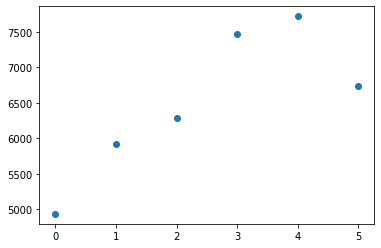

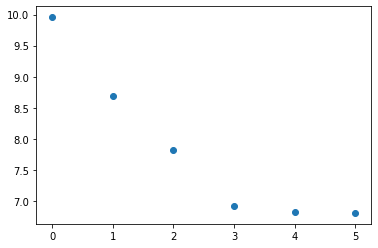

In [317]:
bins=  [-0.1,0.9,1.9,2.9,3.9,5.9,100]

posts_grouped_by_likes = df.groupby(pd.cut(df["n_likes"],bins)).mean().n_posts_by_author.values
plt.scatter(np.arange(len(bins)-1),posts_grouped_by_likes)
plt.show()

posts_grouped_by_likes = df.groupby(pd.cut(df["n_likes"],bins)).count().n_posts_by_author.values
plt.scatter(np.arange(len(bins)-1),np.log(posts_grouped_by_likes))

In [116]:
likes_vs_n_posts = np.array([df.n_likes,df.n_posts_by_author.values]).T

(32367, 2)

In [221]:
n_posts_int = df.n_posts_by_author.values
n_posts_int.shape

(32367,)

In [318]:
validation_tweets = process_tweets(EXTERNAL_VAL_FILE, test_file=False)
X_ext,n_posts_ext = extract_X_y(validation_tweets,feat_type=FEAT_TYPE)

Generating feature vectors
Processing 24584/24584Processing 24131/24584



In [319]:
y_pred_ext = model.predict(X_ext).reshape(-1)
y_pred_int = model.predict(X).reshape(-1)

In [320]:
df_ext = pd.DataFrame()
df_ext['n_posts_by_author']= n_posts_ext#n_posts_int#
df_ext['y_pred_ext']= y_pred_ext#y_pred_int#

In [322]:
df_ext['n_posts_by_author'].describe()

count     24584.00000
mean       6768.53608
std       11824.95723
min           1.00000
25%         979.00000
50%        2806.00000
75%        7388.00000
max      115953.00000
Name: n_posts_by_author, dtype: float64

In [324]:
len(df_ext['n_posts_by_author'].unique())

1390

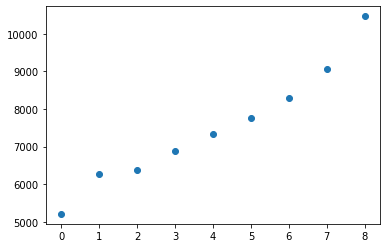

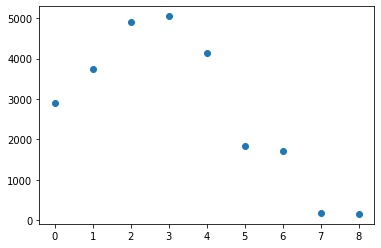

In [335]:
bins=  [0,0.06,0.15,0.25,0.35,0.5,0.65,0.94,0.98,1.01]

posts_grouped_by_likes = df_ext.groupby(pd.cut(df_ext["y_pred_ext"],bins)).mean().n_posts_by_author.values
plt.scatter(np.arange(len(bins)-1),posts_grouped_by_likes)
plt.show()

posts_grouped_by_likes = df_ext.groupby(pd.cut(df_ext["y_pred_ext"],bins)).count().n_posts_by_author.values
plt.scatter(np.arange(len(bins)-1),posts_grouped_by_likes)

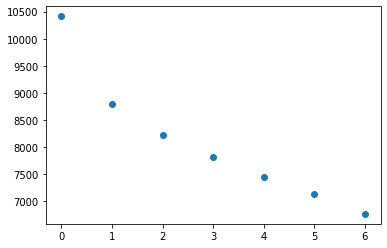

In [355]:
n_posts_ordered = df_ext.sort_values('y_pred_ext',ascending=False).n_posts_by_author.values
total_len = len(n_posts_ordered)
percentages = [0.01,0.03,0.1,0.25,0.5,0.75,1]

res = [np.mean(n_posts_ordered[:int(total_len*percentage)]) for percentage in percentages]

plt.scatter(np.arange(len(res)),res)

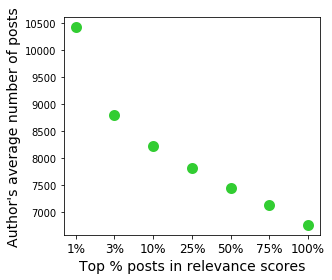

In [374]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.arange(len(res)),res,color='limegreen',lw=5)
#ax.set_ylim([0.5, 0.9])
ax.set_xlabel('Top % posts in relevance scores',fontsize=14)
ax.set_ylabel('Author\'s average number of posts',fontsize=14)
#ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
#ax.yaxis.set_ticks([0.2,0.4,0.6,0.8])
#ax.set_yticklabels(['1%','3%','10%','25%','50%','75%','100%'])
#ax.xaxis.set_ticks([1,5,10,25])
ax.set_xticklabels(['','1%','3%','10%','25%','50%','75%','100%'])
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(12) 
ax.set_aspect(aspect=0.0014)
plt.show()